In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [44]:
# temp_path = '/workspaces/Futures-First/Prediction/LSTM/data/Corn/ZC Jul-Sep'
temp_path = '/workspaces/Futures-First/Prediction/LSTM/data/Copper/HG Dec-Mar'
# files = ['./data/2004.csv', './data/2005.csv', './data/2006.csv','./data/2007.csv', './data/2008.csv', './data/2009.csv','./data/2010.csv', './data/2011.csv', './data/2012.csv','./data/2013.csv', './data/2014.csv', './data/2015.csv','./data/2016.csv', './data/2017.csv', './data/2018.csv','./data/2019.csv', './data/2020.csv', './data/2021.csv','./data/2022.csv', './data/2023.csv', './data/2024.csv']  
# files = [temp_path +'/2016.csv',temp_path +'/2017.csv', temp_path +'/2018.csv',temp_path +'/2019.csv', temp_path +'/2020.csv',temp_path +'/2021.csv',temp_path +'/2022.csv',temp_path +'/2023.csv',temp_path +'/2024.csv',temp_path +'/2025.csv']  
files = [temp_path +'/2015.csv',temp_path +'/2016.csv',temp_path +'/2017.csv', temp_path +'/2018.csv',temp_path +'/2019.csv', temp_path +'/2020.csv',temp_path +'/2021.csv',temp_path +'/2022.csv',temp_path +'/2023.csv',temp_path +'/2024.csv']  


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [46]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [47]:
tag_list = ['Open','High','Low','Close']
tag_index = 3

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.170
***************************************************

Epoch: 2

Val Loss: 0.160
***************************************************

Epoch: 3

Val Loss: 0.158
***************************************************

Epoch: 4

Val Loss: 0.147
***************************************************

Epoch: 5

Val Loss: 0.140
***************************************************

Epoch: 6

Val Loss: 0.131
***************************************************

Epoch: 7

Val Loss: 0.133
***************************************************

Epoch: 8

Val Loss: 0.130
***************************************************

Epoch: 9

Val Loss: 0.123
***************************************************

Epoch: 10

Val Loss: 0.124
***************************************************

Epoch: 11

Val Loss: 0.110
**********************************

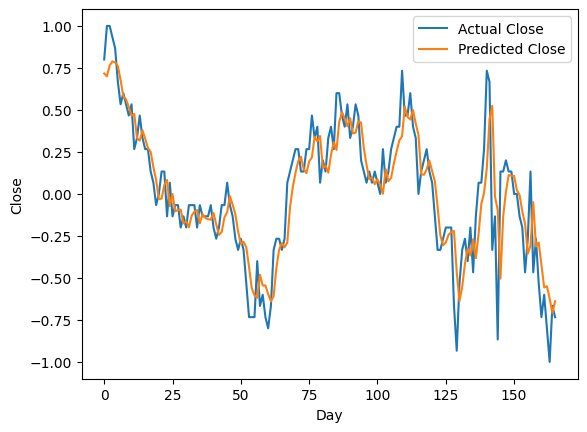

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.262
***************************************************

Epoch: 2

Val Loss: 0.209
***************************************************

Epoch: 3

Val Loss: 0.195
***************************************************

Epoch: 4

Val Loss: 0.188
***************************************************

Epoch: 5

Val Loss: 0.183
***************************************************

Epoch: 6

Val Loss: 0.189
***************************************************

Epoch: 7

Val Loss: 0.183
***************************************************

Epoch: 8

Val Loss: 0.194
***************************************************

Epoch: 9

Val Loss: 0.170
***************************************************

Epoch: 10

Val Loss: 0.164
***************************************************

Epoch: 11

Val Loss: 0.166
**********************************

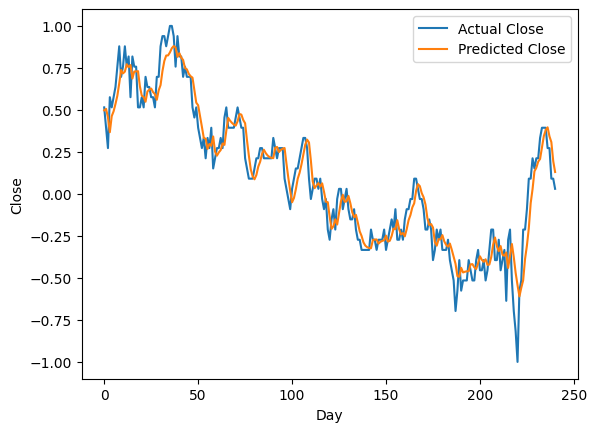

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.295
***************************************************

Epoch: 2

Val Loss: 0.293
***************************************************

Epoch: 3

Val Loss: 0.266
***************************************************

Epoch: 4

Val Loss: 0.231
***************************************************

Epoch: 5

Val Loss: 0.213
***************************************************

Epoch: 6

Val Loss: 0.205
***************************************************

Epoch: 7

Val Loss: 0.180
***************************************************

Epoch: 8

Val Loss: 0.167
***************************************************

Epoch: 9

Val Loss: 0.175
***************************************************

Epoch: 10

Val Loss: 0.164
***************************************************

Epoch: 11

Val Loss: 0.141
**********************************

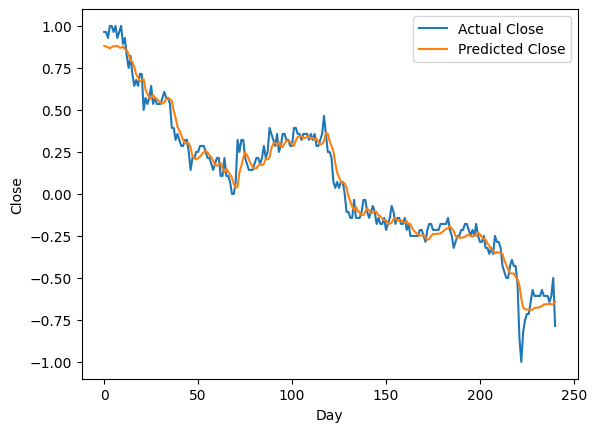

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.160
***************************************************

Epoch: 2

Val Loss: 0.142
***************************************************

Epoch: 3

Val Loss: 0.111
***************************************************

Epoch: 4

Val Loss: 0.102
***************************************************

Epoch: 5

Val Loss: 0.087
***************************************************

Epoch: 6

Val Loss: 0.082
***************************************************

Epoch: 7

Val Loss: 0.086
***************************************************

Epoch: 8

Val Loss: 0.073
***************************************************

Epoch: 9

Val Loss: 0.075
***************************************************

Epoch: 10

Val Loss: 0.061
***************************************************

Epoch: 11

Val Loss: 0.057
**********************************

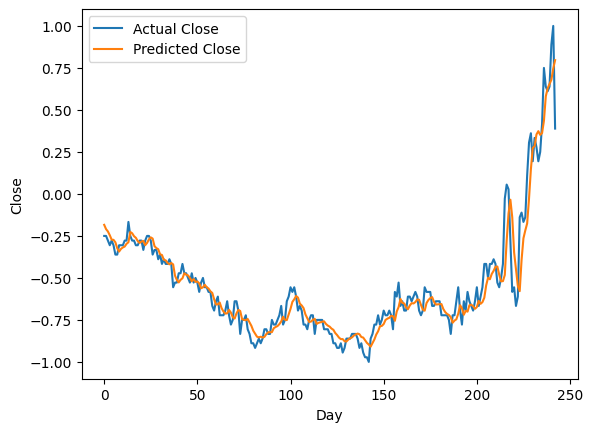

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.185
***************************************************

Epoch: 2

Val Loss: 0.160
***************************************************

Epoch: 3

Val Loss: 0.133
***************************************************

Epoch: 4

Val Loss: 0.119
***************************************************

Epoch: 5

Val Loss: 0.091
***************************************************

Epoch: 6

Val Loss: 0.074
***************************************************

Epoch: 7

Val Loss: 0.066
***************************************************

Epoch: 8

Val Loss: 0.062
***************************************************

Epoch: 9

Val Loss: 0.059
***************************************************

Epoch: 10

Val Loss: 0.057
***************************************************

Epoch: 11

Val Loss: 0.056
**********************************

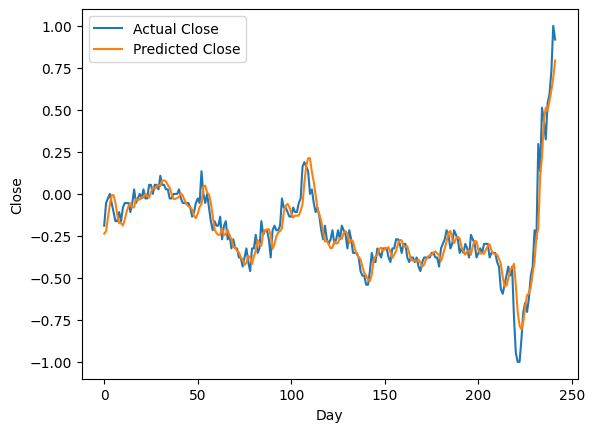

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.450
***************************************************

Epoch: 2

Val Loss: 0.404
***************************************************

Epoch: 3

Val Loss: 0.364
***************************************************

Epoch: 4

Val Loss: 0.326
***************************************************

Epoch: 5

Val Loss: 0.293
***************************************************

Epoch: 6

Val Loss: 0.260
***************************************************

Epoch: 7

Val Loss: 0.227
***************************************************

Epoch: 8

Val Loss: 0.199
***************************************************

Epoch: 9

Val Loss: 0.169
***************************************************

Epoch: 10

Val Loss: 0.141
***************************************************

Epoch: 11

Val Loss: 0.115
**********************************

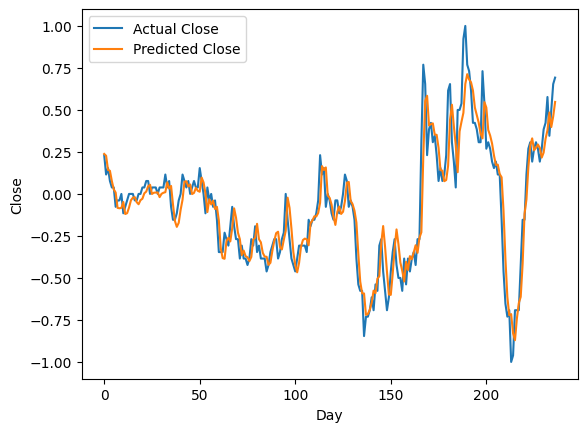

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.916
***************************************************

Epoch: 2

Val Loss: 0.802
***************************************************

Epoch: 3

Val Loss: 0.733
***************************************************

Epoch: 4

Val Loss: 0.645
***************************************************

Epoch: 5

Val Loss: 0.583
***************************************************

Epoch: 6

Val Loss: 0.504
***************************************************

Epoch: 7

Val Loss: 0.441
***************************************************

Epoch: 8

Val Loss: 0.378
***************************************************

Epoch: 9

Val Loss: 0.285
***************************************************

Epoch: 10

Val Loss: 0.248
***************************************************

Epoch: 11

Val Loss: 0.189
**********************************

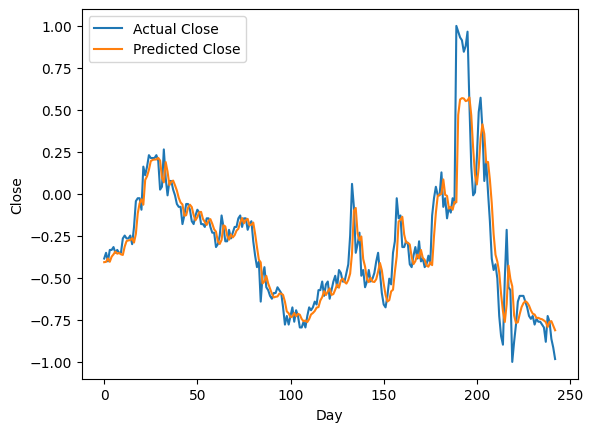

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.424
***************************************************

Epoch: 2

Val Loss: 0.392
***************************************************

Epoch: 3

Val Loss: 0.345
***************************************************

Epoch: 4

Val Loss: 0.320
***************************************************

Epoch: 5

Val Loss: 0.296
***************************************************

Epoch: 6

Val Loss: 0.260
***************************************************

Epoch: 7

Val Loss: 0.243
***************************************************

Epoch: 8

Val Loss: 0.221
***************************************************

Epoch: 9

Val Loss: 0.208
***************************************************

Epoch: 10

Val Loss: 0.195
***************************************************

Epoch: 11

Val Loss: 0.176
**********************************

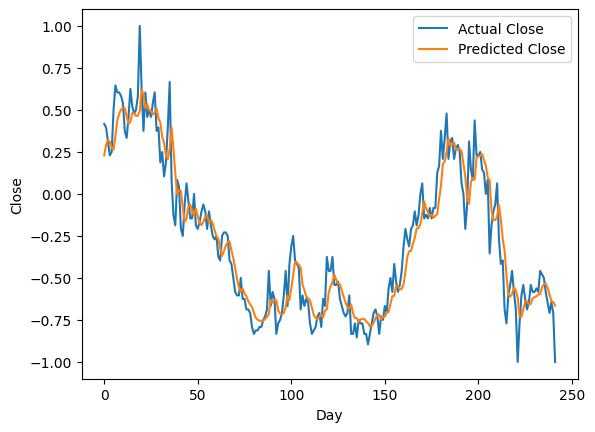

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.293
***************************************************

Epoch: 2

Val Loss: 0.248
***************************************************

Epoch: 3

Val Loss: 0.228
***************************************************

Epoch: 4

Val Loss: 0.197
***************************************************

Epoch: 5

Val Loss: 0.177
***************************************************

Epoch: 6

Val Loss: 0.152
***************************************************

Epoch: 7

Val Loss: 0.141
***************************************************

Epoch: 8

Val Loss: 0.137
***************************************************

Epoch: 9

Val Loss: 0.109
***************************************************

Epoch: 10

Val Loss: 0.104
***************************************************

Epoch: 11

Val Loss: 0.085
**********************************

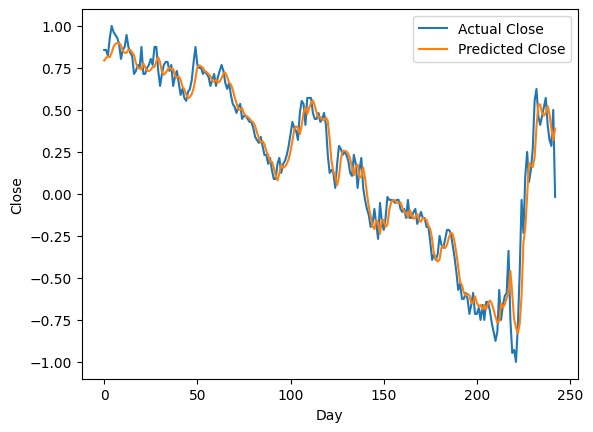

In [48]:
# Function updates
def train_one_epoch(train_loader, model, optimizer, loss_function, epoch):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print(f'Batch {batch_index + 1}, Loss: {avg_loss_across_batches:.3f}')
            running_loss = 0.0
    print()

def validate_one_epoch(test_loader, model, loss_function):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print(f'Val Loss: {avg_loss_across_batches:.3f}')
    print('***************************************************')
    print()

class TimeSeriesDataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.X)

        def __getitem__(self, i):
            return self.X[i], self.y[i]
# Main loop
for file in files[:-1]:  # Exclude the current year's data for training
    # Load and preprocess data
    data = pd.read_csv(file)
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.rename(columns={tag_list[tag_index] :'Price'})
    data = data[['Date', 'Price']]
    # plt.plot(data['Date'], data['Price'])
    # plt.show()  # Show the plot for each file

    # Prepare the data for training
    def prepare_dataframe_for_lstm(df, n_steps):
        df = dc(df)

        df.set_index('Date', inplace=True)

        for i in range(1, n_steps+1):
            df[f'Price(t-{i})'] = df['Price'].shift(i)

        df.dropna(inplace=True)

        return df

    lookback = 10
    shifted_df = prepare_dataframe_for_lstm(data, lookback)

    shifted_df_as_np = shifted_df.to_numpy()
    scaler = MinMaxScaler(feature_range=(-1, 1))
    shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, 0]
    X = dc(np.flip(X, axis=1))

    X = X.reshape((-1, lookback, 1))
    y = y.reshape((-1, 1))

    X = torch.tensor(X).float()
    y = torch.tensor(y).float()

    train_dataset = TimeSeriesDataset(X, y)
    
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for _, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        print(x_batch.shape, y_batch.shape)
        break

    model = LSTM(1, 4, 1)
    model.to(device)
    print(model)

    learning_rate = 0.001
    num_epochs = 100
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        train_one_epoch(train_loader, model, optimizer, loss_function, epoch)
        validate_one_epoch(train_loader, model, loss_function)

    torch.save(model.state_dict(), f'lstm_model_{file.split("/")[-1].split(".")[0]}.pt')
    with torch.no_grad():
        predicted = model(X.to(device)).to('cpu').numpy()

    plt.plot(y, label='Actual Close')
    plt.plot(predicted, label='Predicted Close')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.legend()
    plt.show()


In [49]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
import plotly.graph_objects as go

# Function to prepare data for LSTM
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)
    for i in range(1, n_steps+1):
        df[f'Price(t-{i})'] = df['Price'].shift(i)
    df.dropna(inplace=True)
    return df

# Load and prepare the data
data = pd.read_csv(files[-1])
data['Date'] = pd.to_datetime(data['Date'])
data = data.rename(columns={tag_list[tag_index]:'Price'})
data = data[['Date', 'Price']]

lookback = 10
shifted_df = prepare_dataframe_for_lstm(data, lookback)

shifted_df_as_np = shifted_df.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
X = dc(np.flip(X, axis=1))

X = X.reshape((-1, lookback, 1))
y = y.reshape((-1, 1))

X_test = torch.tensor(X).float()
y_test = torch.tensor(y).float()

# Load the trained model
model_file = '/workspaces/Futures-First/Prediction/LSTM/lstm_model_2023.pt'
model = LSTM(input_size=1, hidden_size=4, num_stacked_layers=1).to(device)
model.load_state_dict(torch.load(model_file))
model.eval()

# Predict the last part of the dataset
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

# Inverse transform the predictions
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, 0])

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_test = dc(dummies[:, 0])

# Prepare for predicting future prices
last_window = X_test[-1].cpu().numpy()

future_predictions = []

# Predict the next 5 days
for _ in range(10):
    # Predict the next price
    pred = model(torch.tensor(last_window).unsqueeze(0).float().to(device)).detach().cpu().numpy().flatten()[0]
    
    # Scale back to original price
    dummies = np.zeros((1, lookback + 1))
    dummies[:, 0] = pred
    dummies = scaler.inverse_transform(dummies)
    
    pred_original = dummies[:, 0][0]
    future_predictions.append(pred_original)
    
    # Update the window for the next prediction
    last_window = np.roll(last_window, -1)
    last_window[-1, 0] = pred

# Combine all predictions
all_predictions = np.concatenate((test_predictions, np.array(future_predictions)))

# Create plotly figure
fig = go.Figure()

# Add traces for actual and predicted values
fig.add_trace(go.Scatter(
    x=np.arange(len(new_y_test)),
    y=new_y_test,
    mode='lines',
    name='Actual Close'
))

fig.add_trace(go.Scatter(
    x=np.arange(len(test_predictions)),
    y=test_predictions,
    mode='lines',
    name='Predicted Close (Past)'
))

fig.add_trace(go.Scatter(
    x=np.arange(len(test_predictions), len(all_predictions)),
    y=future_predictions,
    mode='lines',
    name='Predicted Close (Future)',
    # line=dict(dash='dash')
))

# Update layout
fig.update_layout(
    title="ZW Futures Price Prediction",
    xaxis_title="Day",
    yaxis_title="Price",
    legend_title="Legend"
)

# Show plot
fig.show()


/tmp/ipykernel_14714/775334889.py:43: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [50]:
future_num = [f"{number:.4f}" for number in future_predictions]
future_num,tag_list[tag_index]

(['-0.0396',
  '-0.0382',
  '-0.0370',
  '-0.0361',
  '-0.0352',
  '-0.0346',
  '-0.0340',
  '-0.0335',
  '-0.0331',
  '-0.0327'],
 'Close')

HG- 

OPEN - -0.0420
       -0.0423   -0.0420  -0.0418

HIGH - -0.0380
       -0.0372   -0.0359  -0.0348

LOW-  -0.0470
      -0.0447    -0.0437  -0.0427

CLOSE- -0.0380
       -0.0396  '-0.0382',  -0.0370


ZW Dec Mar- 

OPEN -  -21.00
        -19.0099  -18.7063  -18.4336

HIGH - -20.75
       -18.3430   -18.1017  -17.9478

LOW-    -21.25
        -19.6267'  '-19.2615'  '-18.9909'

CLOSE-  -21.00
        -19.3360  -18.9063  -18.6242

ZC
OPEN - 1.25
       1.1289  1.3446  1.5681

HIGH - 3.25
       0.9690  1.0174  1.0735

LOW-   1.25
       0.5462  0.7300  0.9205

CLOSE- 3.00
       2.0662     2.7128    3.4458

In [53]:
import plotly.graph_objs as go

# OHLC data for two days
ohlc = {
    'Open': [1.25,1.1289,1.3446],
    'High': [3.25,0.9690,1.0174],
    'Low': [1.25,0.5462,0.7300],
    'Close': [3.00,2.0662,2.7128]
}

# Dates for the candlesticks
dates = ['2024-08-25','2024-08-26', '2024-08-27']

# Create a candlestick chart
candle = go.Candlestick(
    x=dates,  # Two dates
    open=ohlc['Open'],
    high=ohlc['High'],
    low=ohlc['Low'],
    close=ohlc['Close']
)

# Create a figure and add the candlestick
fig = go.Figure(data=[candle])

# Update layout to show titles
fig.update_layout(title='Candlesticks for Two Days', xaxis_title='Date', yaxis_title='Price')

# Show the figure
fig.show()
